#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


# 0.요약

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행 
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아님.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것.
        * 성능 가이드
            * Accuracy : 0.900~0.968

## 1.환경설정

### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요X.

In [17]:
path = 'C:/Users/User/Desktop/'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# path = '/content/drive/MyDrive/project/'

### (2) 라이브러리 불러오기

#### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')
# 필요하다고 판단되는 라이브러리를 추가하세요.

#### 2) 제공 함수 생성
* 변수 중요도를 시각화할 수 있는 함수.
* 입력 : 
    * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
    * names : 변수 이름 목록(예 : x_train.columns
    * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
    * topn : 중요도 상위 n개만 표시. all 이면 전체.
* 출력 : 
    * 중요도 그래프 : 중요도 내림차순으로 정렬
    * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 처리사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제

#### 1) 데이터로딩

In [3]:
data01_train = pd.read_csv('data01_train.csv')
data01_test = pd.read_csv('data01_test.csv')
features = pd.read_csv('features.csv')

In [4]:
data01_train.drop('subject', axis=1, inplace=True)
data01_test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [5]:
data01_train.shape, data01_test.shape

((5881, 562), (1471, 562))

In [6]:
display(data01_train.describe().T, data01_test.describe().T)

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",5881.0,0.009340,0.608190,-1.000000,-0.481718,0.011448,0.499857,0.998702
"angle(tBodyGyroJerkMean,gravityMean)",5881.0,-0.007099,0.476738,-1.000000,-0.373345,-0.000847,0.356236,0.996078
"angle(X,gravityMean)",5881.0,-0.491501,0.509069,-1.000000,-0.811397,-0.709441,-0.511330,0.977344
"angle(Y,gravityMean)",5881.0,0.059299,0.297340,-1.000000,-0.018203,0.182893,0.248435,0.478157


,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,1471.0,0.273198,0.079989,-1.000000,0.263787,0.277322,0.288058,0.631510
tBodyAcc-mean()-Y,1471.0,-0.017281,0.045957,-1.000000,-0.024792,-0.017187,-0.010238,0.359587
tBodyAcc-mean()-Z,1471.0,-0.108123,0.049082,-0.418354,-0.120733,-0.108124,-0.096606,0.543939
tBodyAcc-std()-X,1471.0,-0.614634,0.448480,-0.999717,-0.992669,-0.952426,-0.245405,0.899922
tBodyAcc-std()-Y,1471.0,-0.515427,0.506094,-0.999873,-0.979082,-0.867309,-0.030639,0.782590
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",1471.0,0.006272,0.608954,-0.995222,-0.485998,-0.005036,0.518184,0.994366
"angle(tBodyGyroJerkMean,gravityMean)",1471.0,-0.001510,0.483028,-0.969066,-0.380300,0.002408,0.374583,0.979522
"angle(X,gravityMean)",1471.0,-0.481737,0.522714,-0.999380,-0.814060,-0.708911,-0.486534,1.000000
"angle(Y,gravityMean)",1471.0,0.055771,0.298124,-0.995073,-0.017413,0.178814,0.248126,0.432496


In [7]:
print(data01_train.info())
print('='*40)
print(data01_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB
None


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행 


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할

In [8]:
target = 'Activity'
x = data01_train.drop(target, axis=1)
y = data01_train.loc[:, target]

### (2) 스케일링(필요시)


* 세부 처리사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

In [10]:
# (옵션)데이터프레임 변환
x_s = pd.DataFrame(x_s, columns= x.columns)

### (3) 데이터분할2 : train, validation

* 세부 처리사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 함

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y) 

## **3. 기본 모델링**



* 세부 처리사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행. 
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교.

### (1) Random Forest Classifier

#### 1) 전체 변수

In [23]:
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)
y_val_pred = model_rf.predict(x_val)
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

[[335   0   0   0   0   0]
 [  0 285  24   0   0   1]
 [  0  10 316   0   0   0]
 [  0   0   0 294   5   1]
 [  0   0   0   5 230   2]
 [  0   0   0   0   2 255]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       0.97      0.92      0.94       310
          STANDING       0.93      0.97      0.95       326
           WALKING       0.98      0.98      0.98       300
WALKING_DOWNSTAIRS       0.97      0.97      0.97       237
  WALKING_UPSTAIRS       0.98      0.99      0.99       257

          accuracy                           0.97      1765
         macro avg       0.97      0.97      0.97      1765
      weighted avg       0.97      0.97      0.97      1765



#### 2) (옵션)적절히 선택한 변수
* 변수 중요도 상위 100로 결정해서 모델링 해보기
* 변수 중요도 상위 1 ~ 400 까지 변수를 하나씩 늘려가며 모델링 및 성능 비교

,feature_name,feature_importance
0,tGravityAcc-min()-X,0.038566
1,tGravityAcc-mean()-Y,0.026236
2,tGravityAcc-min()-Y,0.024347
3,"angle(X,gravityMean)",0.024289
4,tGravityAcc-energy()-X,0.024270
...,...,...
556,fBodyGyro-entropy()-Z,0.000093
557,fBodyGyro-min()-Y,0.000093
558,"fBodyAccJerk-bandsEnergy()-57,64.2",0.000089
559,fBodyAcc-maxInds-Z,0.000058


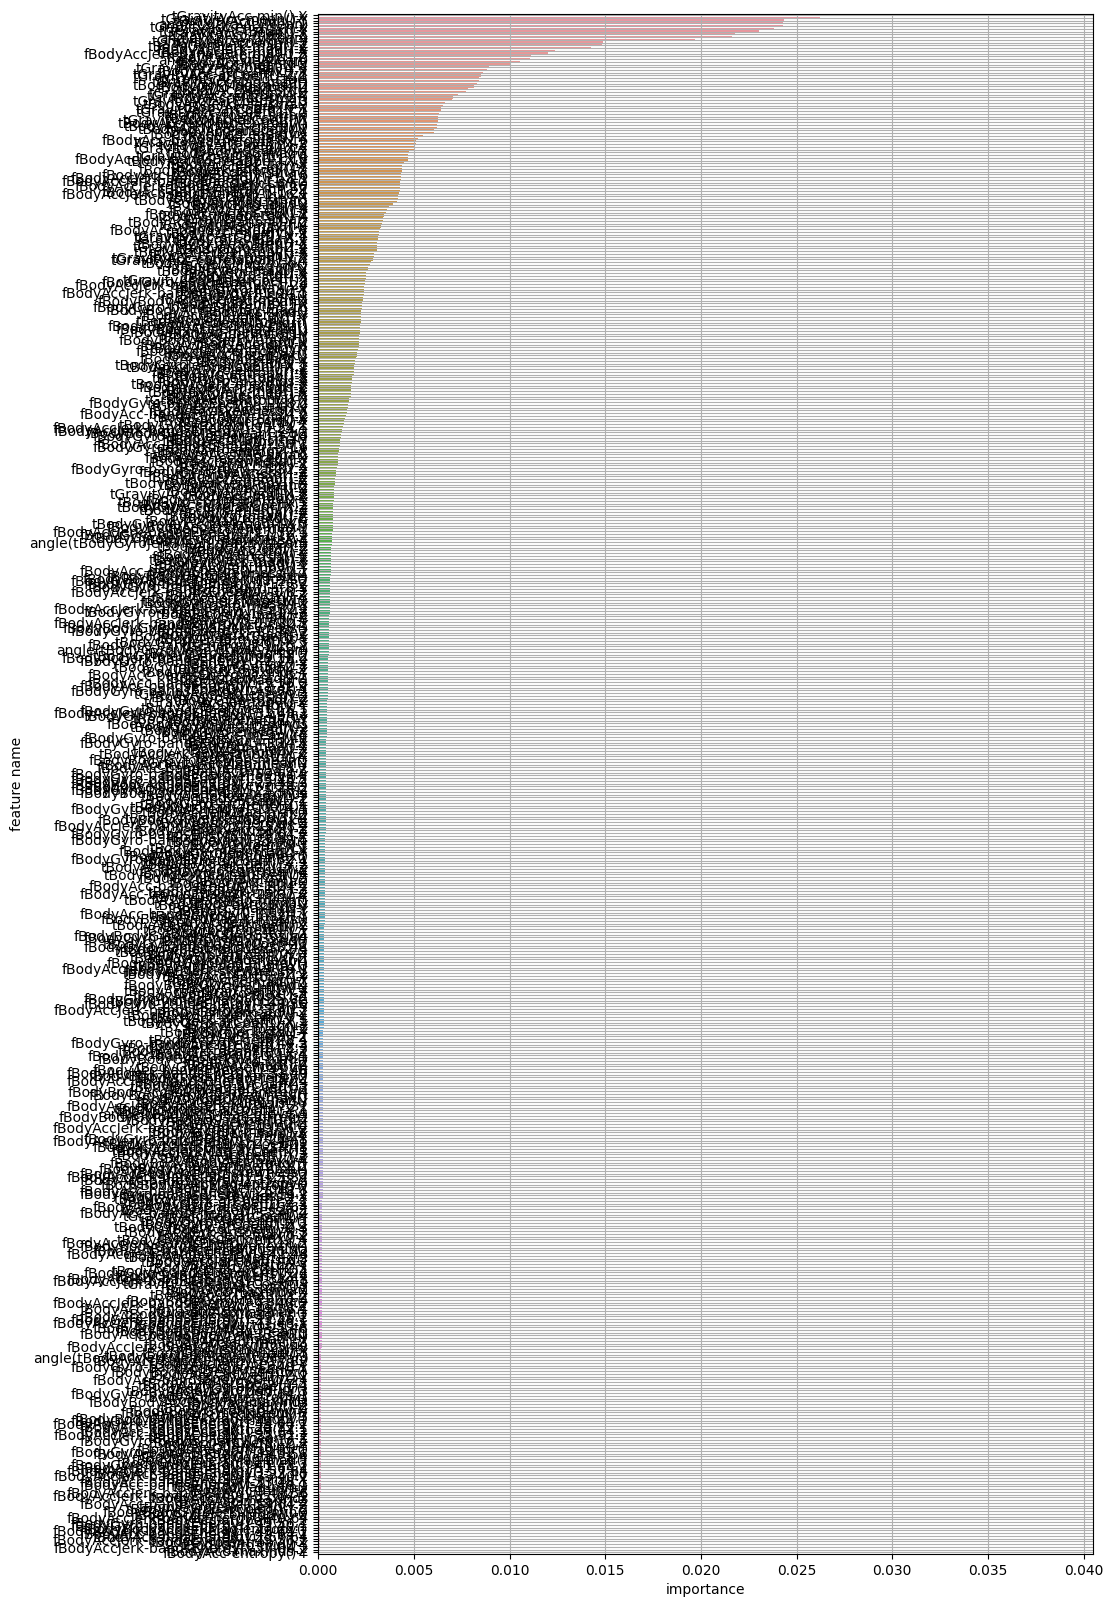

In [24]:
r_sta = plot_feature_importance(model_rf.feature_importances_, list(x_train), False)
r_sta

In [28]:
x_top = r_sta[:100]

* 가장 중요한 변수부터 하나씩 증가시켜가며 모델링 및 accuracy 구하기

In [45]:
x_top_train = x_train.loc[:, list(x_top['feature_name'])]
x_top_val = x_val.loc[:, list(x_top['feature_name'])]


model_rf.fit(x_top_train, y_train)
val_pred = model_rf.predict(x_top_val)
print(accuracy_score(y_val, val_pred))

0.9739376770538244


In [46]:
x_test = data01_test.loc[:, list(x_top['feature_name'])]
y_test = data01_test.loc[:, target]

pred = model_rf.predict(x_test)
print(accuracy_score(y_test, pred))

0.973487423521414


* 적절한 지점의 성능에 맞춰 변수 선택 : ==> 30~50개 정도면 충분!

In [57]:
acc_dict = {}
best_feat = None
best_acc = 0

for i in range(30, 51):
    x_top = r_sta[:i]
    x_top_train = x_train.loc[:, list(x_top['feature_name'])]
    x_top_val = x_val.loc[:, list(x_top['feature_name'])]

    model_rf.fit(x_top_train, y_train)
    val_pred = model_rf.predict(x_top_val)
    acc = accuracy_score(y_val, val_pred)
    
    feat = tuple(x_top_train.columns)
    acc_dict[feat] = acc

    if acc > best_acc:
        best_acc = acc
        best_feat = feat

In [58]:
print('best feat count:', len(best_feat))
print("best feat:", best_feat)
print("best acc:", best_acc)

best feat count: 30
best feat: ('tGravityAcc-min()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-min()-Y', 'angle(X,gravityMean)', 'tGravityAcc-energy()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-mean()-X', 'tGravityAcc-max()-X', 'angle(Y,gravityMean)', 'tGravityAcc-energy()-Y', 'tGravityAcc-min()-Z', 'tBodyGyroJerk-mad()-Z', 'fBodyAccJerk-mad()-X', 'tBodyAccJerk-mad()-X', 'fBodyAccJerk-bandsEnergy()-1,8', 'tGravityAcc-max()-Z', 'angle(Z,gravityMean)', 'fBodyAccMag-std()', 'fBodyAcc-mean()-X', 'tGravityAcc-arCoeff()-Y,3', 'fBodyAccJerk-max()-X', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Z,1', 'tGravityAccMag-std()', 'tGravityAccMag-mad()', 'tBodyAccJerkMag-mean()', 'fBodyGyro-maxInds-Z', 'tBodyAccMag-std()', 'tGravityAcc-energy()-Z', 'tGravityAcc-entropy()-Y')
best acc: 0.9807365439093484


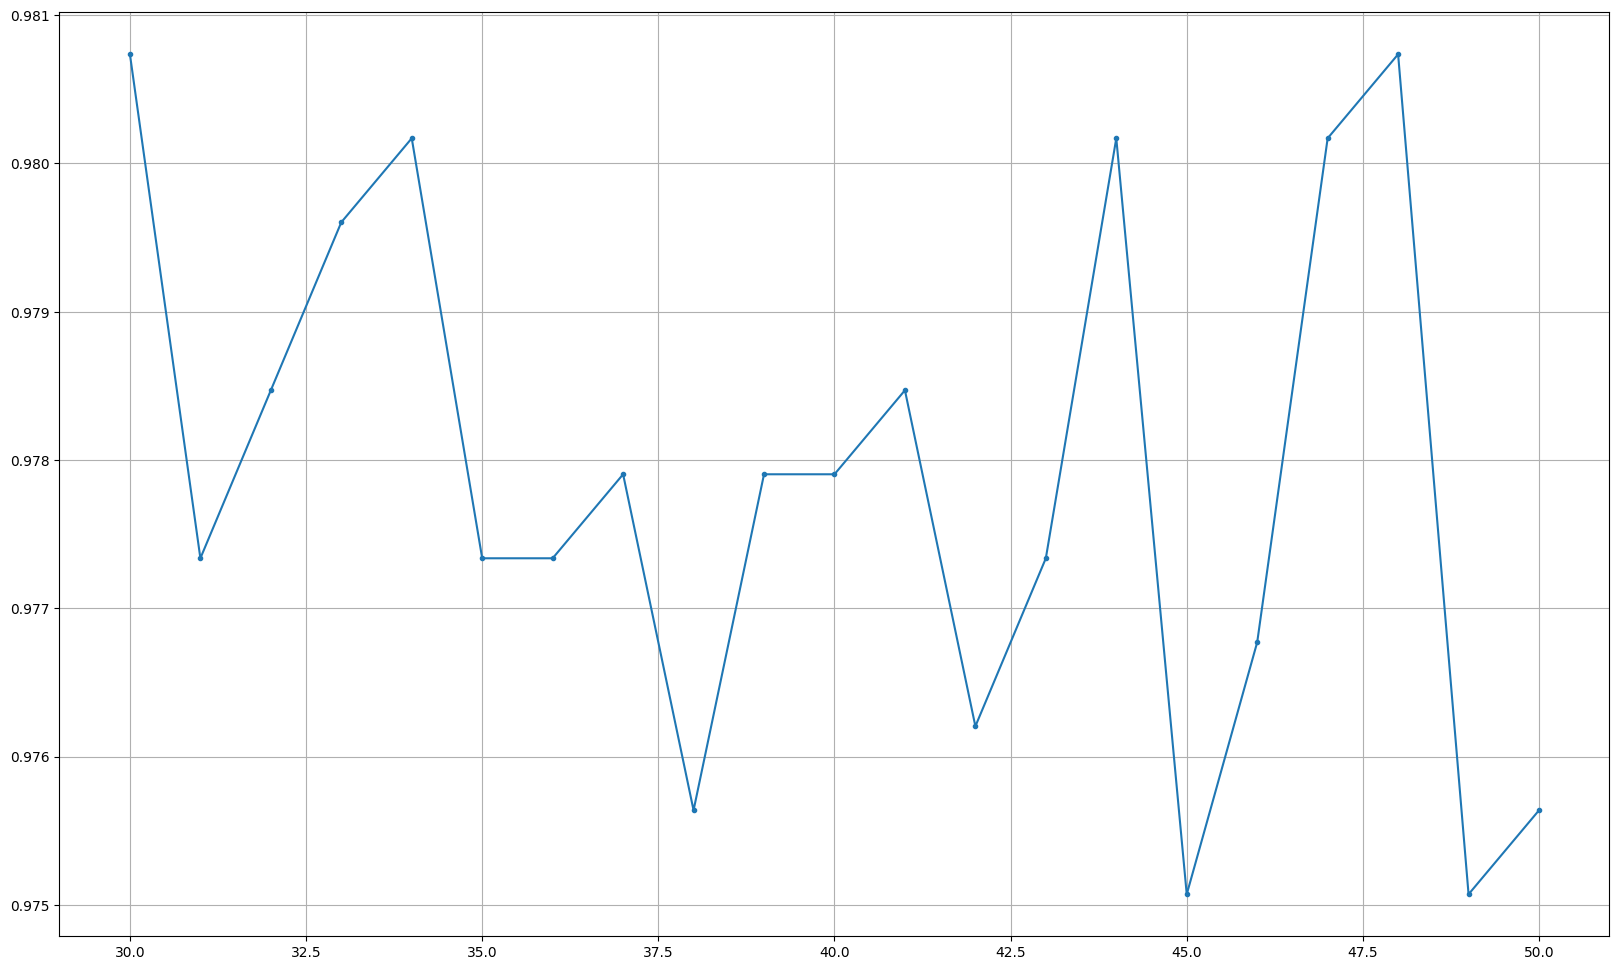

In [71]:
plt.figure(figsize = (20, 12))
plt.plot(range(30, 51), list(acc_dict.values()), marker='.')
plt.grid()
plt.show()

In [59]:
# 평가
x_top = r_sta[:30]

x_top_train = x_train.loc[:, list(x_top['feature_name'])]
x_top_val = x_val.loc[:, list(x_top['feature_name'])]


model_rf.fit(x_top_train, y_train)
val_pred = model_rf.predict(x_top_val)
print('검증 평가:', accuracy_score(y_val, val_pred))

x_test = data01_test.loc[:, list(x_top['feature_name'])]
y_test = data01_test.loc[:, target]

pred = model_rf.predict(x_test)
print('test값 평가:', accuracy_score(y_test, pred))

검증 평가: 0.9807365439093484
test값 평가: 0.972807613868117


### (2) Logistic Regressin

#### 1) 전체 변수

In [64]:
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
model_lo = LogisticRegression()
model_lo.fit(x_train, y_train)
y_val_pred = model_lo.predict(x_val)
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

[[335   0   0   0   0   0]
 [  0 293  16   0   0   1]
 [  0  15 311   0   0   0]
 [  0   0   0 297   1   2]
 [  0   0   0   0 236   1]
 [  0   0   0   1   1 255]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       0.95      0.95      0.95       310
          STANDING       0.95      0.95      0.95       326
           WALKING       1.00      0.99      0.99       300
WALKING_DOWNSTAIRS       0.99      1.00      0.99       237
  WALKING_UPSTAIRS       0.98      0.99      0.99       257

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



#### 2) (옵션)적절히 선택한 변수
* 변수 중요도 상위 100로 모델링 해보기

,feature_name,feature_importance
0,tGravityAcc-mean()-Y,0.817642
1,tGravityAcc-max()-Y,0.801292
2,tGravityAcc-min()-Y,0.787389
3,tBodyGyroJerk-entropy()-X,0.764551
4,"tBodyAccJerk-correlation()-X,Z",0.639913
...,...,...
556,fBodyAccJerk-energy()-X,0.023391
557,"fBodyAccJerk-bandsEnergy()-41,48.1",0.023282
558,"fBodyAccJerk-bandsEnergy()-1,24",0.022996
559,tBodyGyroJerk-min()-Y,0.021063


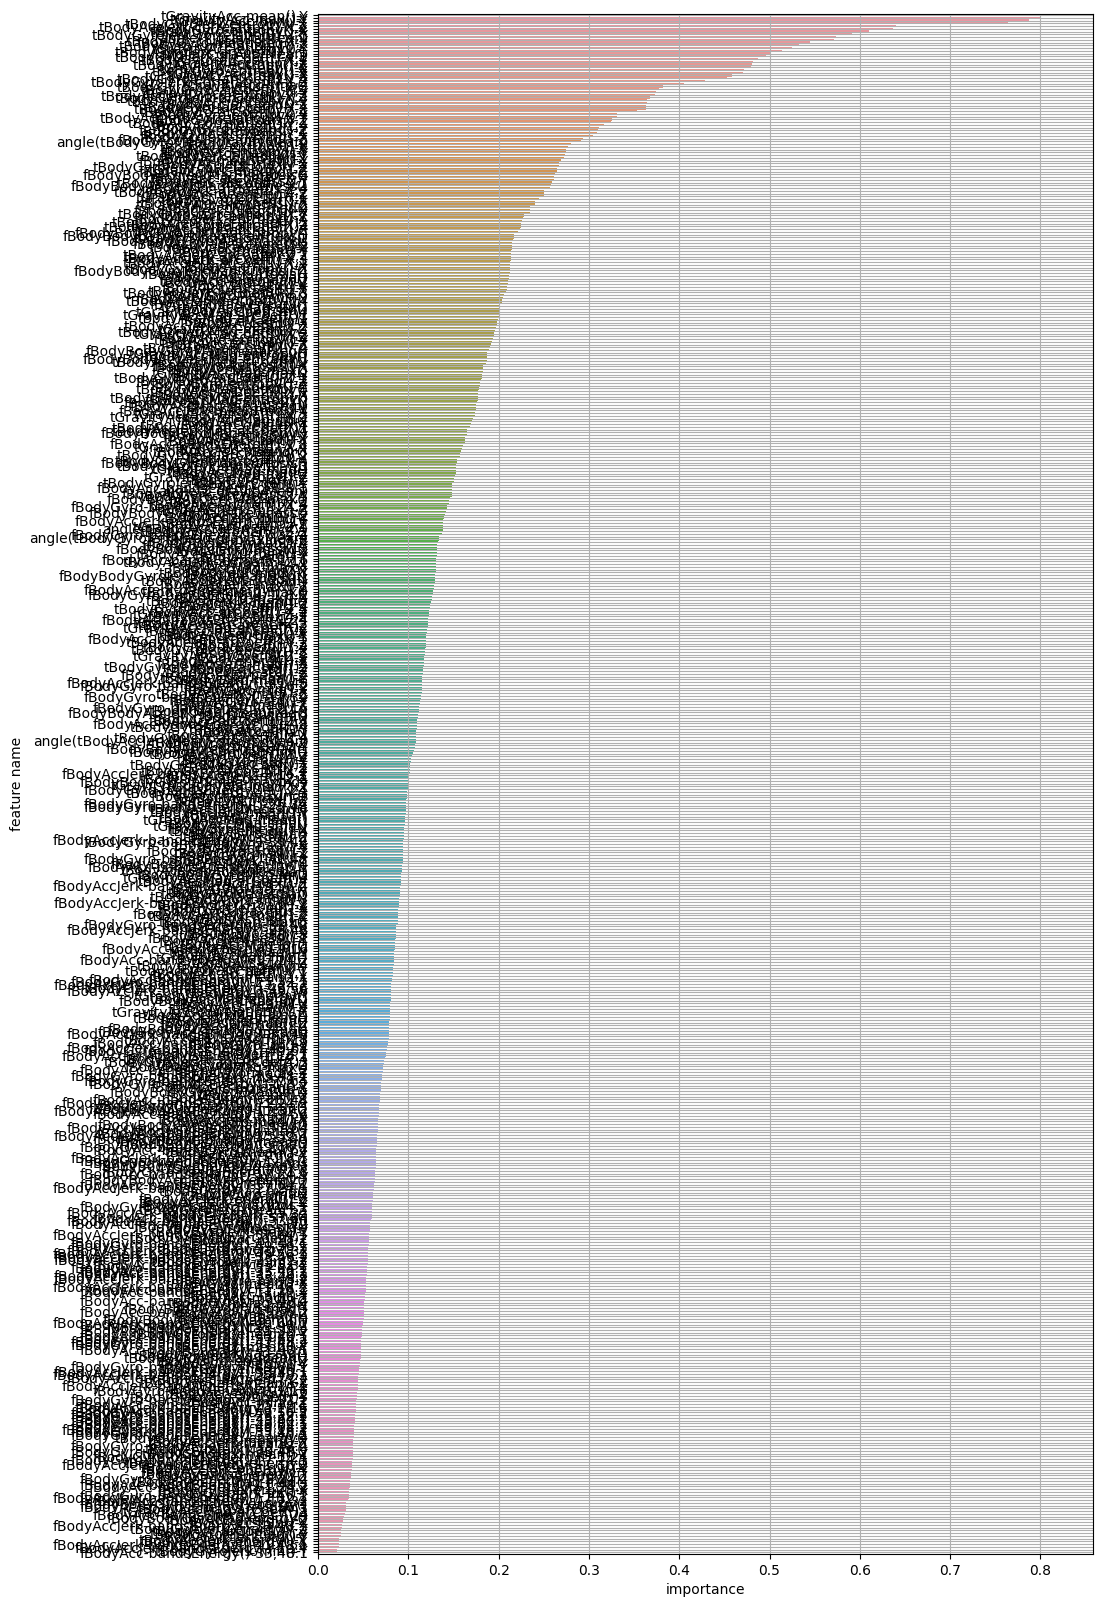

In [73]:
r = plot_feature_importance(pd.DataFrame(model_lo.coef_.__abs__()).sum()/6, list(x_train), False)
r

In [81]:
top_100 = r[:100]['feature_name']
x_top_train = x_train.loc[:, top_100]
x_top_val = x_val.loc[:, top_100]

In [84]:
model_lo.fit(x_top_train, y_train)
val_pred = model_lo.predict(x_top_val)
print(accuracy_score(y_val, val_pred))
print('='*40)
print(confusion_matrix(y_val, val_pred))
print('='*40)
print(classification_report(y_val, val_pred))

0.9796033994334278
[[335   0   0   0   0   0]
 [  0 288  21   0   0   1]
 [  0  10 316   0   0   0]
 [  0   0   0 298   1   1]
 [  0   0   0   0 237   0]
 [  0   0   0   1   1 255]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       0.97      0.93      0.95       310
          STANDING       0.94      0.97      0.95       326
           WALKING       1.00      0.99      0.99       300
WALKING_DOWNSTAIRS       0.99      1.00      1.00       237
  WALKING_UPSTAIRS       0.99      0.99      0.99       257

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



### (3) SVM

#### 1) kernel = 'rbf'

In [85]:
from sklearn.svm import SVC

In [86]:
m3_1 = SVC(C=1, gamma=0.01, kernel='rbf')
m3_1.fit(x_train, y_train)
p3_1 = m3_1.predict(x_val)

In [87]:
print(accuracy_score(y_val, p3_1))
print('='*40)
print(confusion_matrix(y_val, p3_1))
print('='*40)
print(classification_report(y_val, p3_1))

0.9677053824362606
[[335   0   0   0   0   0]
 [  2 277  30   0   0   1]
 [  0  20 306   0   0   0]
 [  0   0   0 299   0   1]
 [  0   0   0   1 236   0]
 [  0   0   0   1   1 255]]
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       335
           SITTING       0.93      0.89      0.91       310
          STANDING       0.91      0.94      0.92       326
           WALKING       0.99      1.00      1.00       300
WALKING_DOWNSTAIRS       1.00      1.00      1.00       237
  WALKING_UPSTAIRS       0.99      0.99      0.99       257

          accuracy                           0.97      1765
         macro avg       0.97      0.97      0.97      1765
      weighted avg       0.97      0.97      0.97      1765



#### 2) kernel = 'linear'

In [88]:
m3_2 = SVC(C=1, gamma=0.01, kernel='linear')
m3_2.fit(x_train, y_train)
p3_2 = m3_2.predict(x_val)

In [89]:
print(accuracy_score(y_val, p3_2))
print('='*40)
print(confusion_matrix(y_val, p3_2))
print('='*40)
print(classification_report(y_val, p3_2))

0.9847025495750709
[[335   0   0   0   0   0]
 [  0 299  10   0   0   1]
 [  0  12 314   0   0   0]
 [  0   0   0 299   0   1]
 [  0   0   0   0 236   1]
 [  0   0   0   1   1 255]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       0.96      0.96      0.96       310
          STANDING       0.97      0.96      0.97       326
           WALKING       1.00      1.00      1.00       300
WALKING_DOWNSTAIRS       1.00      1.00      1.00       237
  WALKING_UPSTAIRS       0.99      0.99      0.99       257

          accuracy                           0.98      1765
         macro avg       0.99      0.99      0.99      1765
      weighted avg       0.98      0.98      0.98      1765



#### 3) 하이퍼파라미터 튜닝

* test 전체 수행하기(12 ~ 15분 소요)

In [90]:
range(1,10)

range(1, 10)

In [92]:
from sklearn.model_selection import GridSearchCV
params = {'C': [0.01, 1, 100],
          'gamma': [0.0001, 0.001, 0.1, 1],
          'kernel': ['linear', 'rbf']}

# refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재학습시킴. 
m3_3 = GridSearchCV(SVC(),
                    params,
                    return_train_score=True,
                    cv=5,
                    scoring='accuracy')

In [93]:
m3_3.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 1, 100], 'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             return_train_score=True, scoring='accuracy')

In [94]:
print('최적 파라미터:', m3_3.best_params_)
print('='*40)
print('최고 성능:', m3_3.best_score_)

최적 파라미터: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
최고 성능: 0.9832376812278074


* 예측 및 평가

In [95]:
p3_3 = m3_3.predict(x_val)

In [96]:
print('Accuracy:', accuracy_score(y_val, p3_3))
print('='*40)
print(confusion_matrix(y_val, p3_3))
print('='*40)
print(classification_report(y_val, p3_3))

Accuracy: 0.9847025495750709
[[335   0   0   0   0   0]
 [  0 299  10   0   0   1]
 [  0  12 314   0   0   0]
 [  0   0   0 299   0   1]
 [  0   0   0   0 236   1]
 [  0   0   0   1   1 255]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       0.96      0.96      0.96       310
          STANDING       0.97      0.96      0.97       326
           WALKING       1.00      1.00      1.00       300
WALKING_DOWNSTAIRS       1.00      1.00      1.00       237
  WALKING_UPSTAIRS       0.99      0.99      0.99       257

          accuracy                           0.98      1765
         macro avg       0.99      0.99      0.99      1765
      weighted avg       0.98      0.98      0.98      1765

